# Project: F1 race prediction

## 1) Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

## 2) Helper Functions

In [2]:
# Convert timestamp to numeric value
def time_str_to_numeric(time_str):
    if isinstance(time_str, str) and time_str != "\\N":
        minutes, seconds = map(float, time_str.split(':'))
        return minutes * 60 + seconds
    else:
        return np.nan

In [3]:
# Map the race positions to the points
def attach_raceId_to_predictions(raceIds, y_pred):
    predictions_with_raceId = pd.DataFrame(raceIds)
    predictions_with_raceId['y_pred'] = y_pred
    predictions_with_raceId['new_y_pred'] = predictions_with_raceId.groupby('raceId')['y_pred'].transform(lambda x: x.rank(ascending=False, method='first'))

    rank_to_points = {1: 25, 2: 18, 3: 15, 4: 12, 5: 10, 6: 8, 7: 6, 8: 4, 9: 2, 10: 1}

    predictions_with_raceId['new_y_pred'] = predictions_with_raceId['new_y_pred'].map(rank_to_points).fillna(0)
    new_y_pred = predictions_with_raceId['new_y_pred'].values

    return new_y_pred

## 3) Data loading
1. All the csv files are in the data sub folder but we only need these 6 csv files

In [4]:
# Read the data from a csv files to dataframes
circuts = pd.read_csv("data/circuits.csv")
constructors = pd.read_csv("data/constructors.csv")
drivers = pd.read_csv("data/drivers.csv")
qualifying = pd.read_csv("data/qualifying.csv")
races = pd.read_csv("data/races.csv")
results = pd.read_csv("data/results.csv")

## 4) Data Pre-Processing

### 4.1) Raw data from multiple csv files

In [5]:
qualifying.head()

,qualifyId,raceId,driverId,constructorId,number,position,q1,q2,q3
0,1,18,1,1,22,1,1:26.572,1:25.187,1:26.714
1,2,18,9,2,4,2,1:26.103,1:25.315,1:26.869
2,3,18,5,1,23,3,1:25.664,1:25.452,1:27.079
3,4,18,13,6,2,4,1:25.994,1:25.691,1:27.178
4,5,18,2,2,3,5,1:25.960,1:25.518,1:27.236


In [6]:
races.head()

,raceId,year,round,circuitId,name,date,time,url,fp1_date,fp1_time,fp2_date,fp2_time,fp3_date,fp3_time,quali_date,quali_time,sprint_date,sprint_time
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N


In [7]:
results.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


### 4.2) Data Selection, Handling missing data , Data Cleaning

In [8]:
# Remove unwanted columns
qualifying = qualifying.drop(['number'], axis = 1)
races = races[['raceId','year','round','circuitId']]
results = results.drop(['number', 'positionText', 'positionOrder','time','milliseconds','rank','statusId'], axis=1)

# Collecting races which happened on or after 2000 for our analysis
races = races[races['year'] >= 2000]
unique_race_ids = races['raceId'].unique()
results = results[results['raceId'].isin(unique_race_ids)]
qualifying = qualifying[qualifying['raceId'].isin(unique_race_ids)]

# Replacing the missing value of fastestLapTime with 100:0 (very large time value)
results['fastestLapTime'] = results['fastestLapTime'].replace({'\\N': '100:0'})

# Replacing the missing value of fastestLapSpeed with 0 (Least speed)
results['fastestLapSpeed'] = results['fastestLapSpeed'].replace({'\\N': '0'})

# Replacing the missing value of fastestLap with 0 (Indicating no lap)
results['fastestLap'] = results['fastestLap'].replace({'\\N': '0'})

# Replacing the missing value of position with 20 (last position)
results['position'] = results['position'].replace({'\\N': '20'})

# Converting the timestamp to numberic values
results['fastestLapTime'] = results['fastestLapTime'].apply(time_str_to_numeric)
qualifying['q1'] = qualifying['q1'].apply(time_str_to_numeric)
qualifying['q2'] = qualifying['q2'].apply(time_str_to_numeric)
qualifying['q3'] = qualifying['q3'].apply(time_str_to_numeric)

# Converting position, fastestLap, fastestLapSpeed from object to int
results['position'] = results['position'].astype(int)
results['fastestLap'] = results['fastestLap'].astype(int)
results['fastestLapSpeed'] = results['fastestLapSpeed'].astype(float)

### 4.3) Feature Engineering
1. Generate qualifying_time feature from q1, q2, q3
2. Generate features grid_pos1, grid_pos2, ..., grid_pos10 to capture past 10 grid positions of that driver
3. Generate features result_pos1, result_pos2, ..., result_pos10 to capture past 10 results positions of that driver
4. We believe that these features will give the models idea about the race car performance and driver skills

In [9]:
# Merge results and races on raceId and create a main dataframe
df = pd.merge(results, races[['raceId','year','circuitId']], on="raceId")

# create qualifying_time feature from q1, q2, q3
qualifying['qualifying_time'] = qualifying[['q1','q2','q3']].min(axis=1)

# adding qualifying_time feature to the main dataframe
df = pd.merge(df, qualifying[["raceId", "driverId", "constructorId", "qualifying_time"]], on=["raceId", "driverId", "constructorId"])

# fill the missing values if any with max value
df['qualifying_time'] = df.groupby('raceId')['qualifying_time'].transform(lambda x: x.fillna(x.max()))

In [10]:
# temporary data frame to generate grid_pos1, grid_pos2, ..., grid_pos10 features
df_grid = pd.merge(races[['raceId','year','round']], results[['raceId','driverId','grid']] , on=['raceId'])
df_grid = df_grid.sort_values(by=['year', 'driverId', 'round'])

previous_rounds = 10

# generating and updating grid_pos1, grid_pos2, ..., grid_pos10 features
for i in range(1, previous_rounds + 1):
    df_grid[f'grid_pos{i}'] = df_grid.groupby(['year', 'driverId'])['grid'].shift(i)

df_grid = df_grid.reset_index(drop=True)

for i in range(1, previous_rounds + 1):
    df_grid.loc[df_grid['round'] <= i, f'grid_pos{i}'] = None

df_grid = df_grid.sort_values(by=['driverId', 'round'])

# Filling the None values with mean values
for i in range(1, previous_rounds + 1):
    if i == 1:
        df_grid[f'grid_pos{i}'].fillna(df_grid['grid'], inplace=True)
    else:
        df_grid[f'grid_pos{i}'].fillna(df_grid[[f'grid_pos{j}' for j in range(1, i)] + ['grid']].mean(axis=1), inplace=True)

# making grid_pos1, grid_pos2, ..., grid_pos10 features as int type
for i in range(1, previous_rounds + 1):
    df_grid[f'grid_pos{i}'] = df_grid[f'grid_pos{i}'].astype(int)

In [11]:
# temporary data frame to generate result_pos1, result_pos2, ..., result_pos10 features
df_result = pd.merge(races[['raceId','year','round']], results[['raceId','driverId','position']] , on=['raceId'])
df_result = df_result.sort_values(by=['year', 'driverId', 'round'])

previous_rounds = 10

# generating and updating result_pos1, result_pos2, ..., result_pos10 features
for i in range(1, previous_rounds + 1):
    df_result[f'result_pos{i}'] = df_result.groupby(['year', 'driverId'])['position'].shift(i)

df_result = df_result.reset_index(drop=True)

for i in range(1, previous_rounds + 1):
    df_result.loc[df_result['round'] <= i, f'result_pos{i}'] = None

df_result = df_result.sort_values(by=['driverId', 'round'])

# Filling the None values with mean values
for i in range(1, previous_rounds + 1):
    if i == 1:
        df_result[f'result_pos{i}'].fillna(df_result['position'], inplace=True)
    else:
        df_result[f'result_pos{i}'].fillna(df_result[[f'result_pos{j}' for j in range(1, i)] + ['position']].mean(axis=1), inplace=True)

# making result_pos1, result_pos2, ..., result_pos10 features as int type
for i in range(1, previous_rounds + 1):
    df_result[f'result_pos{i}'] = df_result[f'result_pos{i}'].astype(int)

In [12]:
# adding grid_pos1, grid_pos2, ..., grid_pos10 feature to the main dataframe
df = pd.merge(df, df_grid[["raceId","driverId","grid_pos1","grid_pos2","grid_pos3","grid_pos4","grid_pos5","grid_pos6","grid_pos7","grid_pos8","grid_pos9","grid_pos10"]], on=["raceId","driverId"])

# adding result_pos1, result_pos2, ..., result_pos10 feature to the main dataframe
df = pd.merge(df, df_result[["raceId","driverId","result_pos1","result_pos2","result_pos3","result_pos4","result_pos5","result_pos6","result_pos7","result_pos8","result_pos9","result_pos10"]], on=["raceId","driverId"])

# position to points mapping
points_mapping = {
    1: 25, 2: 18, 3: 15, 4: 12, 5: 10, 6: 8, 7: 6, 8: 4, 9: 2, 10: 1
}

# modifying points according to the position using our mapping
df['points'] = df['position'].map(points_mapping).fillna(0)

# drop resultId, year, position as they are irrelevant in predictions
df = df.drop(['resultId','year','position'],axis=1)

### 4.4) Descriptive stats of the data and data exploration

In [13]:
df.head()

,raceId,driverId,constructorId,grid,points,laps,fastestLap,fastestLapTime,fastestLapSpeed,circuitId,...,result_pos1,result_pos2,result_pos3,result_pos4,result_pos5,result_pos6,result_pos7,result_pos8,result_pos9,result_pos10
0,18,1,1,1,25.0,58,39,87.452,218.300,1,...,1,1,1,1,1,1,1,1,1,1
1,18,2,2,5,18.0,58,41,87.739,217.586,1,...,2,2,2,2,2,2,2,2,2,2
2,18,3,3,7,15.0,58,41,88.090,216.719,1,...,3,3,3,3,3,3,3,3,3,3
3,18,4,4,11,12.0,58,58,88.603,215.464,1,...,4,4,4,4,4,4,4,4,4,4
4,18,5,1,3,10.0,58,43,87.418,218.385,1,...,5,5,5,5,5,5,5,5,5,5


In [14]:
df.dtypes

raceId               int64
driverId             int64
constructorId        int64
grid                 int64
points             float64
laps                 int64
fastestLap           int64
fastestLapTime     float64
fastestLapSpeed    float64
circuitId            int64
qualifying_time    float64
grid_pos1            int64
grid_pos2            int64
grid_pos3            int64
grid_pos4            int64
grid_pos5            int64
grid_pos6            int64
grid_pos7            int64
grid_pos8            int64
grid_pos9            int64
grid_pos10           int64
result_pos1          int64
result_pos2          int64
result_pos3          int64
result_pos4          int64
result_pos5          int64
result_pos6          int64
result_pos7          int64
result_pos8          int64
result_pos9          int64
result_pos10         int64
dtype: object

In [15]:
df.describe()

,raceId,driverId,constructorId,grid,points,laps,fastestLap,fastestLapTime,fastestLapSpeed,circuitId,...,result_pos1,result_pos2,result_pos3,result_pos4,result_pos5,result_pos6,result_pos7,result_pos8,result_pos9,result_pos10
count,8409.000000,8409.000000,8409.000000,8409.000000,8409.000000,8409.000000,8409.000000,8409.000000,8409.00000,8409.000000,...,8409.000000,8409.000000,8409.000000,8409.000000,8409.000000,8409.000000,8409.000000,8409.000000,8409.000000,8409.000000
mean,648.171483,355.634201,49.058628,10.911167,4.809609,52.434416,38.391247,670.015369,183.45365,19.355809,...,11.329766,11.338923,11.327268,11.309906,11.300987,11.287668,11.259841,11.256987,11.247711,11.224878
std,427.310243,396.306270,75.318693,6.178142,7.086527,18.738098,20.325476,1756.901843,63.80533,20.863197,...,6.394765,6.347120,6.271143,6.186931,6.114017,6.036886,5.943570,5.865866,5.772703,5.676413
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,55.404000,0.00000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,102.000000,14.000000,4.000000,6.000000,0.000000,51.000000,24.000000,81.695000,188.01300,6.000000,...,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,7.000000,7.000000
50%,886.000000,37.000000,9.000000,11.000000,0.000000,56.000000,43.000000,92.804000,202.41400,13.000000,...,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
75%,998.000000,822.000000,51.000000,16.000000,8.000000,66.000000,53.000000,103.256000,214.81500,21.000000,...,17.000000,17.000000,17.000000,17.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
max,1110.000000,858.000000,214.000000,24.000000,25.000000,87.000000,85.000000,6000.000000,257.32000,79.000000,...,24.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000


In [16]:
df.isna().sum()

raceId             0
driverId           0
constructorId      0
grid               0
points             0
laps               0
fastestLap         0
fastestLapTime     0
fastestLapSpeed    0
circuitId          0
qualifying_time    0
grid_pos1          0
grid_pos2          0
grid_pos3          0
grid_pos4          0
grid_pos5          0
grid_pos6          0
grid_pos7          0
grid_pos8          0
grid_pos9          0
grid_pos10         0
result_pos1        0
result_pos2        0
result_pos3        0
result_pos4        0
result_pos5        0
result_pos6        0
result_pos7        0
result_pos8        0
result_pos9        0
result_pos10       0
dtype: int64

In [17]:
print("Number of records = "+str(df.shape[0]))
print("Number of features(including raceID) = "+str(df.shape[1]))

Number of records = 8409
Number of features(including raceID) = 31


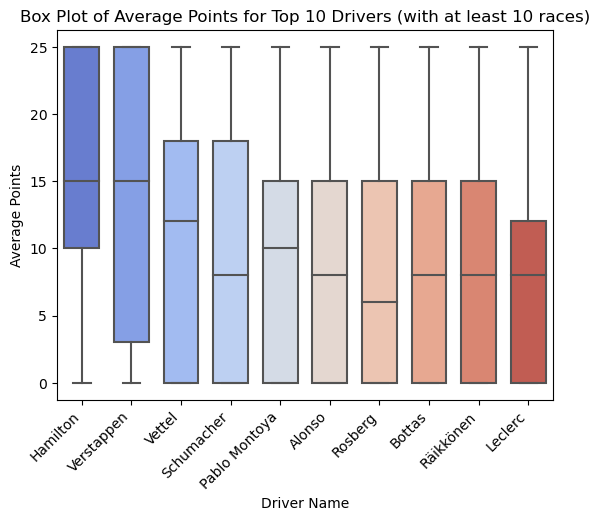

In [18]:
# Count the number of races each driver has participated in
race_counts = df['driverId'].value_counts()

# Filter out drivers with less than 5 races
eligible_drivers = race_counts[race_counts >= 10].index

# Filter the main DataFrame for only eligible drivers
df_eligible = df[df['driverId'].isin(eligible_drivers)]

# Group by driverId and calculate the mean points for each eligible driver
df_avg_points = df_eligible.groupby('driverId')['points'].mean().reset_index()

# Sort the Series by average points in descending order to get the best drivers
df_avg_points_sorted = df_avg_points.sort_values('points', ascending=False)

# Select the top N drivers (adjust N based on your preference)
top_n_drivers = 10
df_top_n_avg_points = df_avg_points_sorted.head(top_n_drivers)

# Merge with the original DataFrame to get additional information including driver names
df_top_n_avg_info = pd.merge(df_top_n_avg_points, df_eligible, on='driverId', how='left')
df_top_n_avg_info = pd.merge(df_top_n_avg_info, drivers[['driverId', 'driverRef', 'forename', 'surname']], on='driverId', how='left')

# Create a box plot using Seaborn with switched axes and a cool color gradient
plt.figure()
sns.boxplot(x='surname', y='points_y', data=df_top_n_avg_info, width=0.7, palette="coolwarm")
plt.title('Box Plot of Average Points for Top {} Drivers (with at least 10 races)'.format(top_n_drivers))
plt.xlabel('Driver Name')
plt.ylabel('Average Points')
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better visibility
plt.show()

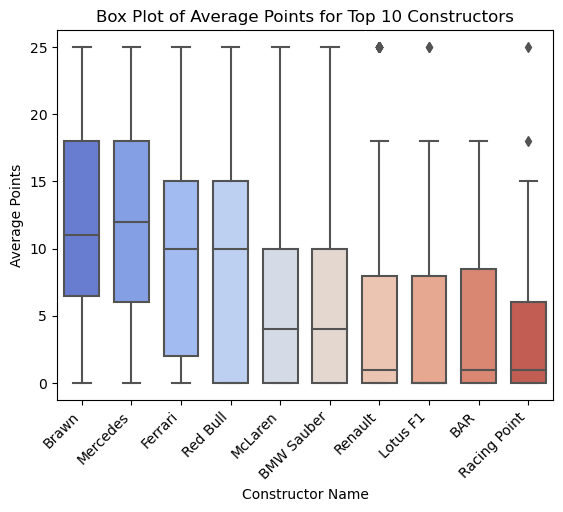

In [19]:
# Group by constructorId and calculate the mean points for each constructor
df_avg_points_constructor = df.groupby('constructorId')['points'].mean().reset_index()

# Sort the DataFrame by average points in descending order to get the best constructors
df_avg_points_constructor_sorted = df_avg_points_constructor.sort_values('points', ascending=False)

# Select the top N constructors (adjust N based on your preference)
top_n_constructors = 10
df_top_n_avg_points_constructor = df_avg_points_constructor_sorted.head(top_n_constructors)

# Merge with the original DataFrame to get additional information including constructor names
df_top_n_avg_info_constructor = pd.merge(df_top_n_avg_points_constructor, df, on='constructorId', how='left')
df_top_n_avg_info_constructor = pd.merge(df_top_n_avg_info_constructor, constructors[['constructorId', 'name']], on='constructorId', how='left')

# Create a box plot using Seaborn with switched axes
plt.figure()
sns.boxplot(x='name', y='points_y', data=df_top_n_avg_info_constructor, width=0.7, palette="coolwarm")
plt.title('Box Plot of Average Points for Top {} Constructors'.format(top_n_constructors))
plt.xlabel('Constructor Name')
plt.ylabel('Average Points')
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better visibility
plt.show()

### 4.5) Feature Correlation Analysis

Number of pairs of feaures which have correlation coefficient > 0.8 = 2.0
Correlation plot:


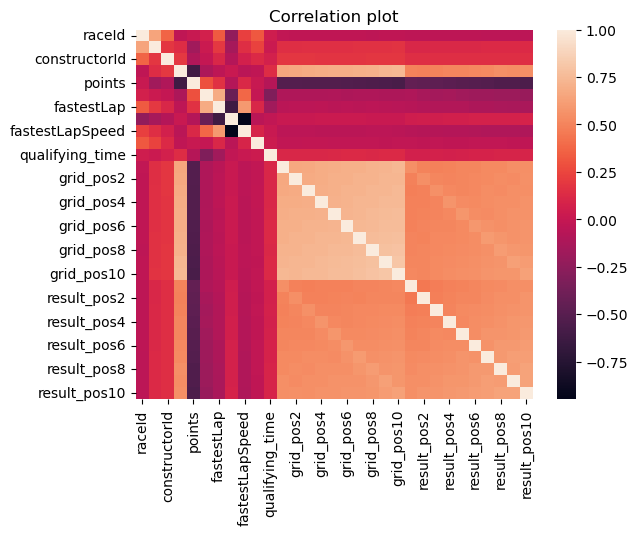

In [20]:
# Pair-wise Correlation of all the features 
correlation = df.corr()

# Number of pairs of feaures which have correlation coefficient > 0.8
correlation_count = (np.sum(np.where(np.abs(correlation)>=0.8,1,0)) - correlation.shape[0])/2
print("Number of pairs of feaures which have correlation coefficient > 0.8 = " + str(correlation_count))

# Correlation heat map plot
plt.title('Correlation plot')
print("Correlation plot:")
sns.heatmap(correlation);

We can observe that the the features are mostly independent and not correlated with eachother. So data reduction using pca or svd is not necessary

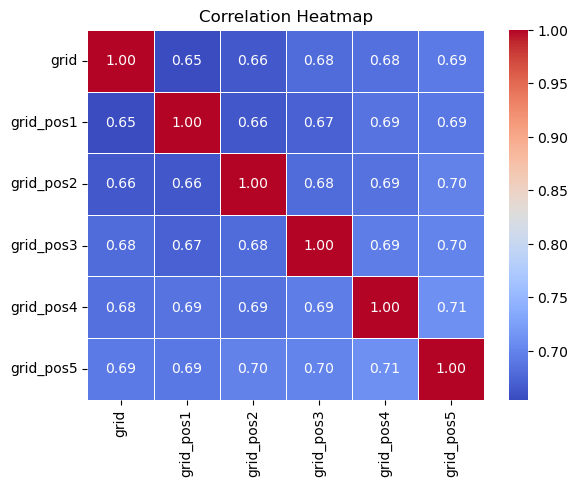

In [21]:
# correlation between 'grid_pos1', 'grid_pos2', 'grid_pos3', 'grid_pos4', 'grid_pos5' and 'grid'
columns_of_interest = ['grid', 'grid_pos1', 'grid_pos2', 'grid_pos3', 'grid_pos4', 'grid_pos5']
df_selected = df[columns_of_interest]

# Calculate the correlation matrix
correlation_matrix = df_selected.corr()

# Create a heatmap using Seaborn
plt.figure()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

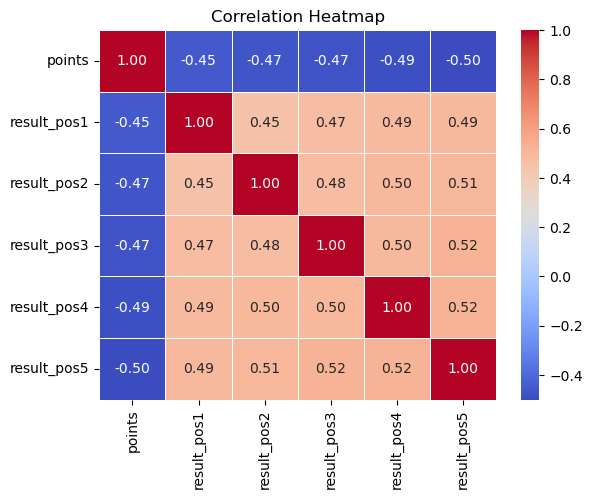

In [22]:
# correlation between 'result_pos1', 'result_pos2', 'result_pos3', 'result_pos4', 'result_pos5' and 'points'
columns_of_interest = ['points', 'result_pos1', 'result_pos2', 'result_pos3', 'result_pos4', 'result_pos5']
df_selected = df[columns_of_interest]

# Calculate the correlation matrix
correlation_matrix = df_selected.corr()

# Create a heatmap using Seaborn
plt.figure()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

### 4.6) Encoding categorical features

In [23]:
# OneHot encoding 'driverId','constructorId','circuitId' (Qualitative Nominal) features
enc = OneHotEncoder()
encoded = enc.fit_transform(df[['driverId','constructorId','circuitId']])
df_enc = df.drop(['driverId','constructorId','circuitId'],axis=1)
df_enc = pd.concat([df_enc,pd.DataFrame(encoded.toarray())],axis =1)
df_enc.columns = df_enc.columns.astype(str)

### 4.7) Data Split to train and test

In [24]:
# get unique raceIds
unique_raceIds = df_enc['raceId'].unique()

# Split the unique raceIds to train(80%) and test(20%)
train_raceIds, test_raceIds = train_test_split(unique_raceIds, test_size=0.2, random_state=42)

# Split the recored corresponding to train_raceIds and test_raceIds
train_set = df_enc[df_enc['raceId'].isin(train_raceIds)]
test_set = df_enc[df_enc['raceId'].isin(test_raceIds)]

train_raceId_list = df_enc[df_enc['raceId'].isin(train_raceIds)]['raceId']
test_raceId_list = df_enc[df_enc['raceId'].isin(test_raceIds)]['raceId']

# Split as X(features) and Y(target)
X_train = train_set.drop(columns=['raceId','points'])
Y_train = train_set['points']

# Split as X(features) and Y(target)
X_test = test_set.drop(columns=['raceId','points'])
Y_test = test_set['points']

In [25]:
print("Train data samples: " +str(X_train.shape[0]))
print("Test data samples: " +str(X_test.shape[0]))

Train data samples: 6720
Test data samples: 1689


## 5) Models

### 5.1) Linear Regression

In [26]:
# Linear regression
linear_reg = LinearRegression().fit(X_train, Y_train)

# Train predictions
Y_train_pred = linear_reg.predict(X_train)
Y_train_pred = attach_raceId_to_predictions(train_raceId_list, Y_train_pred)

# Test predictions
Y_test_pred = linear_reg.predict(X_test)
Y_test_pred = attach_raceId_to_predictions(test_raceId_list, Y_test_pred)

# Calculate R2 score for train and test
linear_reg_train_score = r2_score(Y_train, Y_train_pred)
linear_reg_test_score = r2_score(Y_test, Y_test_pred)

# Calculate RootMeanSquareError for train and test
linear_reg_train_rmse = np.sqrt(mean_squared_error(Y_train, Y_train_pred))
linear_reg_test_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))

# Print the evaluation metics
print("Train R2 score = "+str(linear_reg_train_score))
print("Test R2 score = "+str(linear_reg_test_score))
print("Train RootMeanSquareError = "+str(linear_reg_train_rmse))
print("Test RootMeanSquareError = "+str(linear_reg_test_rmse))

Train R2 score = 0.5642283556406484
Test R2 score = 0.6269702783572284
Train RootMeanSquareError = 4.676005748703134
Test RootMeanSquareError = 4.334312409318795


### 5.2) Ridge Regression

In [27]:
# Ridge regression
ridge_reg = Ridge(alpha=0.001).fit(X_train, Y_train)

# Train predictions
Y_train_pred = ridge_reg.predict(X_train)
Y_train_pred = attach_raceId_to_predictions(train_raceId_list, Y_train_pred)

# Test predictions
Y_test_pred = ridge_reg.predict(X_test)
Y_test_pred = attach_raceId_to_predictions(test_raceId_list, Y_test_pred)

# Calculate R2 score for train and test
ridge_reg_train_score = r2_score(Y_train, Y_train_pred)
ridge_reg_test_score = r2_score(Y_test, Y_test_pred)

# Calculate RootMeanSquareError for train and test
ridge_reg_train_rmse = np.sqrt(mean_squared_error(Y_train, Y_train_pred))
ridge_reg_test_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))

# Print the evaluation metics
print("Train R2 score = "+str(ridge_reg_train_score))
print("Test R2 score = "+str(ridge_reg_test_score))
print("Train RootMeanSquareError = "+str(ridge_reg_train_rmse))
print("Test RootMeanSquareError = "+str(ridge_reg_test_rmse))

Train R2 score = 0.5642283556406484
Test R2 score = 0.6269702783572284
Train RootMeanSquareError = 4.676005748703134
Test RootMeanSquareError = 4.334312409318795


### 5.3) Lasso Regression

In [28]:
# Lasso regression
lasso_reg = Lasso(alpha=0.001).fit(X_train, Y_train)

# Train predictions
Y_train_pred = lasso_reg.predict(X_train)
Y_train_pred = attach_raceId_to_predictions(train_raceId_list, Y_train_pred)

# Test predictions
Y_test_pred = lasso_reg.predict(X_test)
Y_test_pred = attach_raceId_to_predictions(test_raceId_list, Y_test_pred)

# Calculate R2 score for train and test
lasso_reg_train_score = r2_score(Y_train, Y_train_pred)
lasso_reg_test_score = r2_score(Y_test, Y_test_pred)

# Calculate RootMeanSquareError for train and test
lasso_reg_train_rmse = np.sqrt(mean_squared_error(Y_train, Y_train_pred))
lasso_reg_test_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))

# Print the evaluation metics
print("Train R2 score = "+str(lasso_reg_train_score))
print("Test R2 score = "+str(lasso_reg_test_score))
print("Train RootMeanSquareError = "+str(lasso_reg_train_rmse))
print("Test RootMeanSquareError = "+str(lasso_reg_test_rmse))

Train R2 score = 0.5620751959433383
Test R2 score = 0.6258651792764083
Train RootMeanSquareError = 4.687543650590411
Test RootMeanSquareError = 4.3407278531196845


### 5.4) Decision Tree

In [29]:
# hyper-parameter tuning on max_depth parameter
param_grid = {
    'max_depth': [2, 4, 6, 8,10, 12, 14, 16, 32, 64],
}

# Decision tree regression
decisiontree_reg = DecisionTreeRegressor(random_state=42)

# Grid search on max_depth hyper-parameter tuning
decisiontree_reg_grid_search = GridSearchCV(estimator= decisiontree_reg, param_grid=param_grid, scoring='r2')
decisiontree_reg_grid_result = decisiontree_reg_grid_search.fit(X_train, Y_train)

# Get best model and it's hyper paramets
decisiontree_reg_best_params = decisiontree_reg_grid_result.best_params_
decisiontree_reg_best_model = decisiontree_reg_grid_result.best_estimator_

# Train predictions on best model
Y_train_pred = decisiontree_reg_best_model.predict(X_train)
Y_train_pred = attach_raceId_to_predictions(train_raceId_list, Y_train_pred)

# Test predictions on best model
Y_test_pred = decisiontree_reg_best_model.predict(X_test)
Y_test_pred = attach_raceId_to_predictions(test_raceId_list, Y_test_pred)

# Calculate R2 score for train and test
decisiontree_reg_train_score = r2_score(Y_train, Y_train_pred)
decisiontree_reg_test_score = r2_score(Y_test, Y_test_pred)

# Calculate RootMeanSquareError for train and test
decisiontree_reg_train_rmse = np.sqrt(mean_squared_error(Y_train, Y_train_pred))
decisiontree_reg_test_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))

# Print the evaluation metics
print("Train R2 score = "+str(decisiontree_reg_train_score))
print("Test R2 score = "+str(decisiontree_reg_test_score))
print("Train RootMeanSquareError = "+str(decisiontree_reg_train_rmse))
print("Test RootMeanSquareError = "+str(decisiontree_reg_test_rmse))
print("Best Prameters: "+str(decisiontree_reg_best_params))

Train R2 score = 0.6671885375302121
Test R2 score = 0.615166879664214
Train RootMeanSquareError = 4.086435896148786
Test RootMeanSquareError = 4.402351489630001
Best Prameters: {'max_depth': 6}


### 5.5) Random Forest 

In [30]:
# hyper-parameter tuning on max_depth and n_estimators parameter 
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [2, 4, 6, 8,10, 12, 14, 16, 32, 64],
}

# Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Grid search on max_depth hyper-parameter tuning
rf_model_grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='r2', cv=5)
rf_model_grid_result = rf_model_grid_search.fit(X_train, Y_train)

# Get best model and it's hyper paramets
rf_model_best_params = rf_model_grid_result.best_params_
rf_model_best_model = rf_model_grid_result.best_estimator_

# Train predictions on best model
Y_train_pred = rf_model_best_model.predict(X_train)
Y_train_pred = attach_raceId_to_predictions(train_raceId_list, Y_train_pred)

# Test predictions on best model
Y_test_pred = rf_model_best_model.predict(X_test)
Y_test_pred = attach_raceId_to_predictions(test_raceId_list, Y_test_pred)

# Calculate R2 score for train and test
rf_model_train_score = r2_score(Y_train, Y_train_pred)
rf_model_test_score = r2_score(Y_test, Y_test_pred)

# Calculate RootMeanSquareError for train and test
rf_model_train_rmse = np.sqrt(mean_squared_error(Y_train, Y_train_pred))
rf_model_test_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))

# Print the evaluation metics
print("Train R2 score = "+str(rf_model_train_score))
print("Test R2 score = "+str(rf_model_test_score))
print("Train RootMeanSquareError = "+str(rf_model_train_rmse))
print("Test RootMeanSquareError = "+str(rf_model_test_rmse))
print("Best Prameters: "+str(rf_model_best_params))

Train R2 score = 0.9596860884772198
Test R2 score = 0.6946634752440572
Train RootMeanSquareError = 1.422240435771272
Test RootMeanSquareError = 3.9213704543665497
Best Prameters: {'max_depth': 16, 'n_estimators': 250}


### 5.6) XGBoost

In [31]:
# hyper-parameter tuning on these parameter 
param_grid = {
    'max_depth': [4, 6],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [50, 100, 150],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.9],
    'colsample_bytree': [0.9],
}

# XGBoost Regressor
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror')

# 5-fold cross validation and Grid search on max_depth hyper-parameter tuning
kf = KFold(n_splits=5, shuffle=True, random_state=42)
xgb_regressor_grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=kf)
xgb_regressor_grid_result = xgb_regressor_grid_search.fit(X_train, Y_train)

# Get best model and it's hyper paramets
xgb_regressor_best_params = xgb_regressor_grid_result.best_params_
xgb_regressor_best_model = xgb_regressor_grid_result.best_estimator_

# Train predictions on best model
Y_train_pred = xgb_regressor_best_model.predict(X_train)
Y_train_pred = attach_raceId_to_predictions(train_raceId_list, Y_train_pred)

# Test predictions on best model
Y_test_pred = xgb_regressor_best_model.predict(X_test)
Y_test_pred = attach_raceId_to_predictions(test_raceId_list, Y_test_pred)

# Calculate R2 score for train and test
xgb_regressor_train_score = r2_score(Y_train, Y_train_pred)
xgb_regressor_test_score = r2_score(Y_test, Y_test_pred)

# Calculate RootMeanSquareError for train and test
xgb_regressor_train_rmse = np.sqrt(mean_squared_error(Y_train, Y_train_pred))
xgb_regressor_test_rmse = np.sqrt(mean_squared_error(Y_test, Y_test_pred))

# Print the evaluation metics
print("Train R2 score = "+str(xgb_regressor_train_score))
print("Test R2 score = "+str(xgb_regressor_test_score))
print("Train RootMeanSquareError = "+str(xgb_regressor_train_rmse))
print("Test RootMeanSquareError = "+str(xgb_regressor_test_rmse))
print("Best Prameters: "+str(xgb_regressor_best_params))

Train R2 score = 0.8991484910371411
Test R2 score = 0.7305909517439093
Train RootMeanSquareError = 2.24950391356469
Test RootMeanSquareError = 3.6834483290333226
Best Prameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.9}


## 6) Results, Models Evaluations and Conclusion

### 6.1) R2 score comparion plot

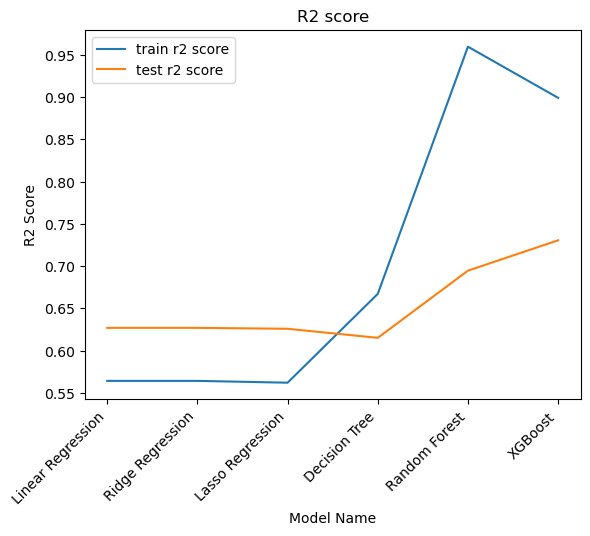

In [32]:
# different model comparisions with R2 metrics
models = ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
train_r2 = [linear_reg_train_score, ridge_reg_train_score, lasso_reg_train_score, decisiontree_reg_train_score, rf_model_train_score, xgb_regressor_train_score]
test_r2 = [linear_reg_test_score, ridge_reg_test_score, lasso_reg_test_score, decisiontree_reg_test_score, rf_model_test_score, xgb_regressor_test_score]

plt.plot(models, train_r2, label = 'train r2 score')
plt.plot(models, test_r2, label = 'test r2 score')
plt.title('R2 score')
plt.xlabel('Model Name')
plt.ylabel('R2 Score')
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better visibility
plt.legend()
plt.show()

### 6.2) RMSE comparion plot

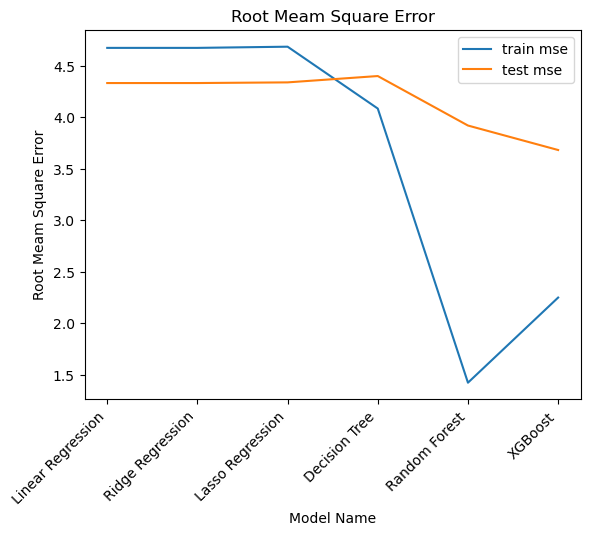

In [33]:
# different model comparisions MSE metrics
models = ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
train_r2 = [linear_reg_train_rmse, ridge_reg_train_rmse, lasso_reg_train_rmse, decisiontree_reg_train_rmse, rf_model_train_rmse, xgb_regressor_train_rmse]
test_r2 = [linear_reg_test_rmse, ridge_reg_test_rmse, lasso_reg_test_rmse, decisiontree_reg_test_rmse, rf_model_test_rmse, xgb_regressor_test_rmse]

plt.plot(models, train_r2, label = 'train mse')
plt.plot(models, test_r2, label = 'test mse')
plt.title('Root Meam Square Error')
plt.xlabel('Model Name')
plt.ylabel('Root Meam Square Error')
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better visibility
plt.legend()
plt.show()

### 6.3) Decision tree top 5 important features

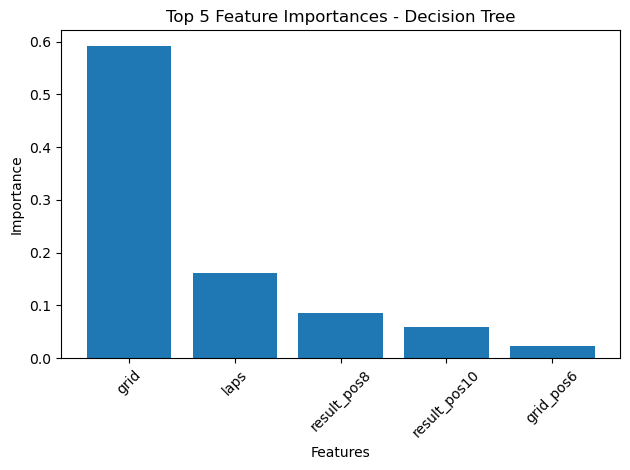

In [34]:
# Get feature importances
decisiontree_reg_importances = decisiontree_reg_best_model.feature_importances_
indices = np.argsort(decisiontree_reg_importances)[::-1]

# Get top 5 feature indices and importances
top_5_indices = indices[:5]
top_5_importances = decisiontree_reg_importances[top_5_indices]
top_5_feature_names = [X_train.columns[i] for i in top_5_indices]

# Plot the top 5 feature importances
plt.figure()
plt.title("Top 5 Feature Importances - Decision Tree")
plt.bar(range(len(top_5_importances)), top_5_importances, align="center")
plt.xticks(range(len(top_5_importances)), top_5_feature_names, rotation=45)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

### 6.4) Random Forest top 5 important features

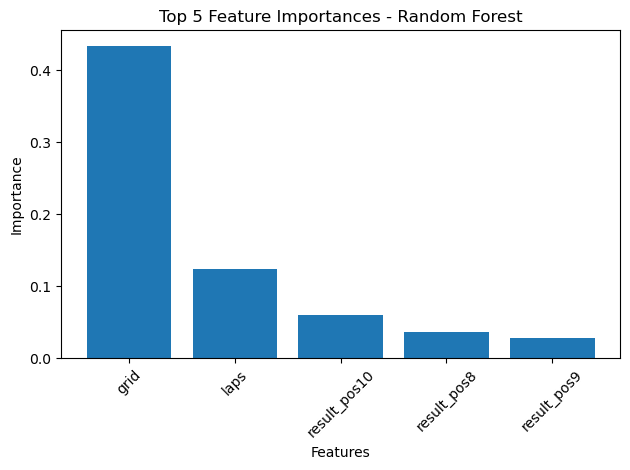

In [35]:
# Get feature importances
rf_model_importances = rf_model_best_model.feature_importances_
indices = np.argsort(rf_model_importances)[::-1]

# Get top 5 feature indices and importances
top_5_indices = indices[:5]
top_5_importances = rf_model_importances[top_5_indices]
top_5_feature_names = [X_train.columns[i] for i in top_5_indices]

# Plot the top 5 feature importances
plt.figure()
plt.title("Top 5 Feature Importances - Random Forest")
plt.bar(range(len(top_5_importances)), top_5_importances, align="center")
plt.xticks(range(len(top_5_importances)), top_5_feature_names, rotation=45)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

### 6.3) XGBoost top 5 important features

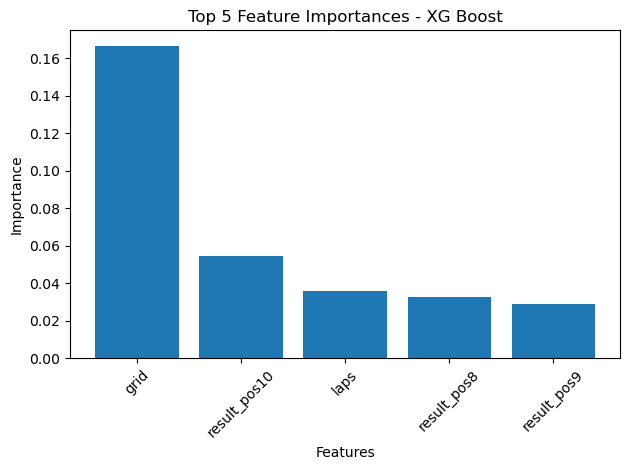

In [36]:
# Get feature importances
xgb_regressor_importances = xgb_regressor_best_model.feature_importances_
indices = np.argsort(xgb_regressor_importances)[::-1]

# Get top 5 feature indices and importances
top_5_indices = indices[:5]
top_5_importances = xgb_regressor_importances[top_5_indices]
top_5_feature_names = [X_train.columns[i] for i in top_5_indices]

# Plot the top 5 feature importances
plt.figure()
plt.title("Top 5 Feature Importances - XG Boost")
plt.bar(range(len(top_5_importances)), top_5_importances, align="center")
plt.xticks(range(len(top_5_importances)), top_5_feature_names, rotation=45)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

### 6.4) Final remarks and conclusion

1. Since it's a regression problem, we wanted to start with basic regression model and go to more complex models. That's why we trained our data on 'Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Decision Tree', 'Random Forest' and 'XGBoost' untill we got the reasonably performaing model
2. Since it's a regression problem we choose RMSE and R2 score as metrics for model evaluations
3. Based on the R2 scores and RMSE values we can see that 'XGBoost' outperforams all the other models 'Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Decision Tree', 'Random Forest'
4. 'Linear Regression', 'Ridge Regression', 'Lasso Regression' didn't give good results the R2 score are less than 0.6 and have high RMSE
5. There is a slight improvement when we come to 'Decision Tree' because of increase in model complexity
6. Performance of ensemble methods 'Random Forest' and 'XGBoost' are higher than 'Decision Tree' which is expected and between 'Random Forest' and 'XGBoost', 'XGBoost' outperformed 'Random Forest'
7. Given the complexity of the problem we are trying to study these results makes sense because as the model complexity increases we observe good results
8. From the feature imporance of all 'Decision Tree', 'Random Forest' and 'XGBoost' models we can see that features grid, laps, result_pos10, result_pos9, result_pos8 seems to have high significance while deciding the points in the race
9. This makes sense beacuse all grid, laps, result_pos10, result_pos9, result_pos8 in someway indicates the performance of the race car and driver